# Vision Quest

In [1]:
from jyro.simulator import *
from conx import *
from IPython.display import display
import random
import numpy as np

conx, version 3.2.1
Using Theano backend.


In [2]:
def make_world(physics):
    physics.addBox(0, 0, 5, 5, fill="gray", wallcolor="gray")
    physics.addBox(0, 0, 0.5, 0.5, fill="blue", wallcolor="blue")
    physics.addBox(0, 5, 0.5, 4.5 , fill="red", wallcolor="red")
    physics.addBox(4.5, 4.5, 5, 5, fill="green", wallcolor="green")
    physics.addBox(4.5, 0, 5, 0.5, fill="purple", wallcolor="purple")
    physics.addBox(2, 1.75, 2.5, 3.25, fill="orange", wallcolor="orange")
    physics.addLight(3, 2.5, 1)

def make_robot():
    robot = Pioneer("Pioneer", 3, 1, 0) 
    robot.addDevice(Camera())
    robot.addDevice(Pioneer16Sonars())
    robot.addDevice(PioneerFrontLightSensors(3))
    return robot

robot = make_robot()
robot.mystep = 0
robot.priority = random.choice(["left", "right"])
sim = Simulator(robot, make_world)

def get_quadrant(x, y, max_x=5, max_y=5):
    if x <= max_x/2 and y <= max_y/2:
        return 1
    elif x <= max_x/2 and y >= max_y/2:
        return 2
    elif x >= max_x/2 and y >= max_y/2:
        return 3
    else:
        return 4
    
def controller(robot):
    if robot.mystep % 200 == 0:
        robot.priority = "left" if robot.priority == "right" else "right"
    image = robot["camera"].getData()
    robot.images.append(image)
    x, y, h = robot.getPose()
    robot.targets.append(get_quadrant(x, y))
    sonar = robot["sonar"].getData()
    left = min(sonar[0:4])
    right = min(sonar[4:8])
    clearance = 0.5
    noise = random.gauss(0, 0.2)
    if robot.priority == "left":
        if left < clearance or right < clearance:
            robot.move(0, -0.5+noise)
        else:
            robot.move(0.5+noise, 0)
    else:
        if left < clearance or right < clearance:
            robot.move(0, 0.5+noise)
        else:
            robot.move(0.5+noise, 0)
    robot.mystep += 1

robot.brain = controller 
robot.images = []
robot.targets = []


In [3]:
# for i in range(2000):
#     if i % 100 == 0:
#         print(i, end=" ")
#     #display(robot["camera"].getImage())
#     sim.step(run_brain=True)
# with open("vision_images.npy", "wb") as fp:
#     np.save(fp, robot.images)
# with open("vision_targets.npy", "wb") as fp:
#     np.save(fp, robot.targets)
# print("done collecting data")

In [4]:
!ls -l *.npy

-rw-r--r-- 1 dblank dblank 57600096 Oct 14 17:23 vision_images.npy
-rw-r--r-- 1 dblank dblank    16080 Oct 14 17:23 vision_targets.npy


In [5]:
vision_images = np.load("vision_images.npy")
print(vision_images.shape)
vision_targets = np.load("vision_targets.npy")
print(vision_targets.shape)

(2000, 40, 60, 3)
(2000,)


In [6]:
ls = list(vision_targets)
x = [ls.count(n) for n in [1,2,3,4]]
print(x)
print(sum(x))

[612, 827, 326, 235]
2000


<IPython.core.display.Javascript object>

<Network name='Vision Controller' (compiled)>
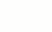
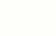
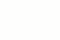

[0.2992382049560547,
 0.27075448632240295,
 0.16441848874092102,
 0.26558881998062134]

In [7]:
from conx import *
def vision_network(actf):
    net = Network("Vision Controller")
    net.add(Layer("img_input", (40,60,3)))
    net.add(Conv2DLayer("conv1", 10, (5, 5), 
                        activation=actf))
    net.add(Conv2DLayer("conv2", 10, (5, 5), 
                        activation=actf))
    net.add(MaxPool2DLayer("pool1", 
                           pool_size=(2,2)))
    net.add(FlattenLayer("flatten"))
    net.add(Layer("hidden", 20, 
                  activation=actf))
    net.add(Layer("output", 4, 
                  activation="softmax"))
    net.connect()
    net.compile(loss="categorical_crossentropy", 
                optimizer="adam")
    return net

net = vision_network("relu")
net["conv1"].feature = 7
display(net)
net.propagate(vision_images[0])

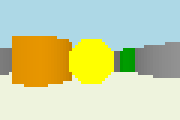

In [8]:
img = array2image(vision_images[0], scale=3.0)
img

In [9]:
net.propagate(vision_images[0])

[0.2992382049560547,
 0.27075448632240295,
 0.16441848874092102,
 0.26558881998062134]

<IPython.core.display.Javascript object>


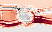
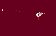
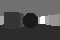

In [10]:
net.snapshot(vision_images[0])

Feature 0,Feature 1,Feature 2,Feature 3,Feature 4
Feature 5,Feature 6,Feature 7,Feature 8,Feature 9

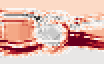
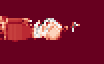
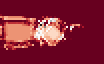
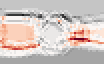
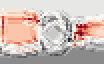
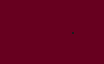
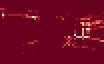
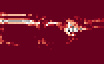
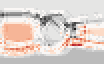
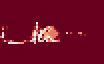

In [11]:
net.propagate_to_features("conv2", vision_images[0], scale=2.0)

In [12]:
ds = net.dataset

In [14]:
%%time
dataset = []
for i in range(len(vision_images)):
    dataset.append([vision_images[i], one_hot(vision_targets[i] - 1, 4)])
ds.load(dataset)

CPU times: user 120 ms, sys: 48 ms, total: 168 ms
Wall time: 166 ms


In [16]:
ds.summary()

Input Summary:
   count  : 4000 (4000 for training, 0 for testing)
   shape  : (40, 60, 3)
   range  : (0.0, 1.0)
Target Summary:
   count  : 4000 (4000 for training, 0 for testing)
   shape  : (4,)
   range  : (0.0, 1.0)


In [15]:
net.train(1, report_rate=1)

Training...
Epoch 1/1
4000/4000 [==============================] - 15s - loss: 1.3881 - acc: 0.1465
Epoch #    1 | train error 1.38812 | train accuracy 0.14650 | validate% 0.88100


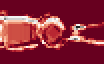

In [16]:
image = net.propagate_to_image("conv2", vision_images[0], scale=2.0)
image

Feature 0,Feature 1,Feature 2,Feature 3,Feature 4
Feature 5,Feature 6,Feature 7,Feature 8,Feature 9

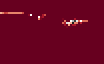
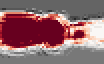
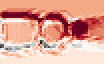
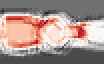
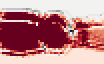
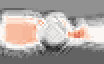
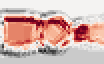
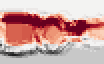
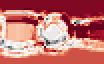
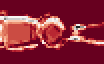

In [17]:
net.propagate_to_features("conv2", vision_images[0], scale=2.0)

In [18]:
net.test()

Testing on training dataset...
# | inputs | targets | outputs | result
---------------------------------------
0 | [[[0.68,0.85,0.90],  [0.68,0.85,0.90],  [0.68,0.85,0.90],  ...,   [0.68,0.85,0.90],  [0.68,0.85,0.90],  [0.68,0.85,0.90]], [[0.68,0.85,0.90],  [0.68,0.85,0.90],  [0.68,0.85,0.90],  ...,   [0.68,0.85,0.90],  [0.68,0.85,0.90],  [0.68,0.85,0.90]], [[0.68,0.85,0.90],  [0.68,0.85,0.90],  [0.68,0.85,0.90],  ...,   [0.68,0.85,0.90],  [0.68,0.85,0.90],  [0.68,0.85,0.90]], ...,  [[0.93,0.95,0.87],  [0.93,0.95,0.87],  [0.93,0.95,0.87],  ...,   [0.93,0.95,0.87],  [0.93,0.95,0.87],  [0.93,0.95,0.87]], [[0.93,0.95,0.87],  [0.93,0.95,0.87],  [0.93,0.95,0.87],  ...,   [0.93,0.95,0.87],  [0.93,0.95,0.87],  [0.93,0.95,0.87]], [[0.93,0.95,0.87],  [0.93,0.95,0.87],  [0.93,0.95,0.87],  ...,   [0.93,0.95,0.87],  [0.93,0.95,0.87],  [0.93,0.95,0.87]]] | [0.00,0.00,0.00,1.00] | [0.24,0.58,0.05,0.14] | X
1 | [[[0.68,0.85,0.90],  [0.68,0.85,0.90],  [0.68,0.85,0.90],  ...,   [0.68,0.85,0.90],  [0.68

In [19]:
def network_brain(robot):
    if robot.mystep % 200 == 0:
        robot.priority = "left" if robot.priority == "right" else "right"
    inputs = robot["camera"].getData()
    outputs = net.propagate(inputs)
    print(net.pf(outputs))
    sonar = robot["sonar"].getData()
    left = min(sonar[0:4])
    right = min(sonar[4:8])
    clearance = 0.5
    noise = random.gauss(0, 0.2)
    if robot.priority == "left":
        if left < clearance or right < clearance:
            robot.move(0, -0.5+noise)
        else:
            robot.move(0.5+noise, 0)
    else:
        if left < clearance or right < clearance:
            robot.move(0, 0.5+noise)
        else:
            robot.move(0.5+noise, 0)
    robot.mystep += 1

In [20]:
net.visualize = False
robot = make_robot()
robot.brain = network_brain
robot.mystep = 0
robot.priority = random.choice(["left", "right"])
vsim = VSimulator(robot, make_world)

VBox(children=(VBox(children=(HBox(children=(Checkbox(value=True, description='Update GUI'), Checkbox(value=False, description='Trace Path'), Text(value='0.0 seconds', description='Time:'))), HBox(children=(VBox(children=(HBox(children=(FloatSlider(value=0.0, layout=Layout(height='248px', padding='0px 0px 0px 0px', width='10px'), orientation='vertical', readout=False), HTML(value='<svg baseProfile="full" height="240" version="1.1" width="240" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><rect fill="#bebebe" height="240.0" stroke="#bebebe" stroke-width="1" width="240.0" x="0.0" y="0.0" /><rect fill="#0000ff" height="24.0" stroke="#0000ff" stroke-width="1" width="24.0" x="0.0" y="216.0" /><rect fill="#ff0000" height="24.0" stroke="#ff0000" stroke-width="1" width="24.0" x="0.0" y="0.0" /><rect fill="#00ff00" height="24.0" stroke="#00ff00" stroke-width="1" width="24.0" x="216.0" y="0.0" /><rect fill="#a020f0" height="24.0" stroke="#a020f0" stroke-width="1" width="24.0" x="216.0" y="216.0" /><rect fill="#ffa500" height="72.0" stroke="#ffa500" stroke-width="1" width="24.0" x="96.0" y="84.0" /><circle cx="144.0" cy="120.0" fill="#ffff00" r="12.0" stroke="#ffff00" stroke-width="1" /><line fill="#800080" stroke="#a020f0" stroke-width="1" x1="144.0" x2="0.0" y1="192.0" y2="108.8615568" /><line fill="#800080" stroke="#a020f0" stroke-width="1" x1="144.0" x2="240.0" y1="192.0" y2="136.5743712" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="135.60000000000002" x2="0.0" y1="187.2" y2="187.2" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="136.8" x2="0.0" y1="183.84" y2="120.0491088" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="138.72" x2="116.56776971347098" y1="182.39999999999998" y2="156.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="141.60000000000002" x2="120.0" y1="181.2" y2="100.58770320000002" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="146.39999999999998" x2="194.95239461779016" y1="181.2" y2="0.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="149.28" x2="240.0" y1="182.39999999999998" y2="74.2841136" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="151.2" x2="240.0" y1="183.84" y2="142.43187840000002" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="152.39999999999998" x2="240.0" y1="187.2" y2="187.2" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="152.39999999999998" x2="240.0" y1="196.79999999999998" y2="196.79999999999998" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="151.2" x2="216.0" y1="200.16" y2="230.3767368" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="149.28" x2="181.50142579808443" y1="201.60000000000002" y2="240.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="146.39999999999998" x2="156.36770979558236" y1="202.79999999999998" y2="240.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="141.60000000000002" x2="131.63229020441764" y1="202.79999999999998" y2="240.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="138.72" x2="106.49857420191556" y1="201.60000000000002" y2="240.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="136.8" x2="51.36284732162905" y1="200.16" y2="240.0" /><line fill="#800080" stroke="#add8e6" stroke-width="1" x1="135.60000000000002" x2="0.0" y1="196.79999999999998" y2="196.79999999999998" /><line fill="#800080" stroke="#ffa500" stroke-width="1" x1="144.0" x2="135.60000000000002" y1="120.0" y2="181.2" /><line fill="#800080" stroke="#ffa500" stroke-width="1" x1="144.0" x2="152.39999999999998" y1="120.0" y2="181.2" /><polygon fill="red" points="140.16,181.2 135.60000000000002,184.8 135.60000000000002,199.20000000000002 140.16,202.79999999999998 147.84,202.79999999999998 152.39999999999998,199.20000000000002 152.39999999999998,184.8 147.84,181.2" stroke="red" stroke-width="1" /><polygon points="-2.400000000000